In [1]:
# Importing required Libraries
import pandas as pd

In [2]:
data=pd.read_csv('Converted_file.csv')

In [3]:
data.head()

,date,location_ordinal,sku,price,discount,color_desc,style_desc,pid_desc,district_ordinal,state_ordinal,Discount,store_ID
0,20160131,1,234,8.0,2.61,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.32625,961
1,20160131,1,325,8.0,2.61,GREY/BLACK,SM GRY/BK STP BS BSC,SM GRY/BK STP BS BSC,6,9,0.32625,961
2,20160131,1,454,8.0,2.60,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32500,961
3,20160131,1,456,8.0,2.58,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32250,961
4,20160131,1,458,8.0,2.61,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32625,961


## Data Cleaning

In [73]:
# Changing the 7.98 price to 8
data.loc[data['price'] == 7.98, 'price'] = 8
# Removing data with negative values of discount
data=data.loc[data['discount']>=0,]
# Converting 'date' column to required date format
data['date']=pd.to_datetime((data['date']), format='%Y%m%d')

data.head()

,date,location_ordinal,sku,price,discount,color_desc,style_desc,pid_desc,district_ordinal,state_ordinal,Discount,store_ID
0,2016-01-31,1,234,8.0,2.61,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.32625,961
1,2016-01-31,1,325,8.0,2.61,GREY/BLACK,SM GRY/BK STP BS BSC,SM GRY/BK STP BS BSC,6,9,0.32625,961
2,2016-01-31,1,454,8.0,2.60,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32500,961
3,2016-01-31,1,456,8.0,2.58,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32250,961
4,2016-01-31,1,458,8.0,2.61,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32625,961


In [74]:
# Finding number of entries for Store-SKU combination
store_sku_counts=data.groupby(['sku', 'store_ID']).size().reset_index(name='counts')

In [75]:
store_sku_counts[store_sku_counts.counts==store_sku_counts.counts.max()]

,sku,store_ID,counts
37799,656,943,380


## Clustering Based on Style Description and Average Discount

In [76]:
cluster_mapping=pd.read_csv('cluster_mapping.csv')
data=data.merge(cluster_mapping,left_on='style_desc',right_on='style_desc')

In [77]:
# Using store number 943 and  sku 656 for our initial CRF
crf_store_sku=data[(data.sku==656) & (data.store_ID==943)]


In [78]:
x_values=crf_store_sku.date.reset_index(drop=1)
y_values=crf_store_sku.Discount.reset_index(drop=1)

In [79]:
import matplotlib.pyplot as plt

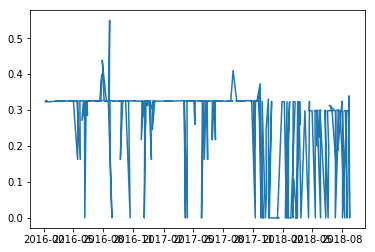

In [80]:
plt.plot(x_values,y_values)

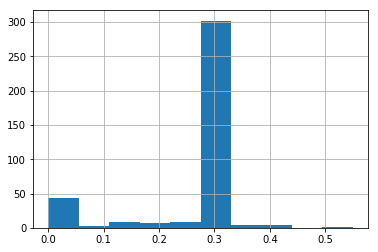

In [81]:
crf_store_sku.Discount.hist()

In [70]:
# Aggregating Weekly for getting a continuous sequence

0 --> A

0-20--> B

20-35--> C

35-40--> D

40-60-->E

60+-->F

In [82]:
#  Function for Genrating buckets for discount percentage
def generate_bucket(discount):
    if(discount==0):
        return('A')
    elif(discount<0.20):
        return('B')
    elif(discount<0.35):
        return('C')
    elif(discount<0.40):
        return('D')
    elif(discount<0.60):
        return('E')
    else:
        return('F')
        

In [83]:
crf_store_sku=crf_store_sku.reset_index(drop=1)
# Generating Min date
min_date=data.date.min()
#Finding week_number
week_number=[]
for i in range(0,len(crf_store_sku.date) ):
    week_number.append(round((crf_store_sku.date[i]-min_date).days/7))
crf_store_sku['week_number']=week_number

In [84]:
#Getting weekly discount for the given CRF ( store:943,sku:656)
weekly_discount=crf_store_sku.groupby(['week_number']).Discount.mean().reset_index()
# For missing weeks, we impute by mean discount for the CRF
missing_week_numbers=list(set(list(range(weekly_discount.week_number.min(),weekly_discount.week_number.max())))-set(list(weekly_discount.week_number)))
missing_week_discount=pd.DataFrame(list(zip(missing_week_numbers, [crf_store_sku.Discount.mean()]*len(missing_week_numbers) )),
              columns=['week_number','Discount'])
weekly_discount=weekly_discount.append(missing_week_discount).sort_values(by=['week_number']).reset_index(drop=1)


In [85]:
#Creating Discount Bucket with our generate_bucket Function
weekly_discount['discount_bucket']=weekly_discount.Discount.apply(generate_bucket)

In [86]:
data.head()

,date,location_ordinal,sku,price,discount,color_desc,style_desc,pid_desc,district_ordinal,state_ordinal,Discount,store_ID,Cluster
0,2016-01-31,1,234,8.0,2.61,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.32625,961,F
1,2016-02-07,1,236,8.0,2.61,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.32625,961,F
2,2016-03-05,1,236,8.0,2.60,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.32500,961,F
3,2016-03-18,1,237,8.0,0.00,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.00000,961,F
4,2016-07-09,1,236,8.0,2.60,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.32500,961,F


In [87]:
sku_cluster=list(data[data.sku==656].Cluster)[1]

In [88]:
#Finding X values (weekly average discount values for CRFs in the same cluster in the same store: 943)
crf_store_cluster=data[(data.sku!=656) & (data.store_ID==943) & (data.Cluster==sku_cluster)]


In [89]:
crf_store_cluster=crf_store_cluster.reset_index(drop=1)
#Finding week_number
week_number=[]
for i in range(0,len(crf_store_cluster.date) ):
    week_number.append(round((crf_store_cluster.date[i]-min_date).days/7))
crf_store_cluster['week_number']=week_number

#Getting weekly discount for the given all other CRF for thesame cluster except sku:656
weekly_cluster_discount=crf_store_cluster.groupby(['week_number']).Discount.mean().reset_index()
# For missing weeks, we impute by mean discount for the CRF
missing_week_numbers=list(set(list(range(weekly_cluster_discount.week_number.min(),weekly_cluster_discount.week_number.max())))-set(list(weekly_cluster_discount.week_number)))
missing_week_discount=pd.DataFrame(list(zip(missing_week_numbers, [crf_store_cluster.Discount.mean()]*len(missing_week_numbers) )),
              columns=['week_number','Discount'])
weekly_cluster_discount=weekly_cluster_discount.append(missing_week_discount).sort_values(by=['week_number']).reset_index(drop=1)
weekly_cluster_discount=weekly_cluster_discount[weekly_cluster_discount.week_number.isin(weekly_discount.week_number)].reset_index(drop=1)

# Generating CRFs

In [90]:
import pycrfsuite

### Our X estimate is the cluster weekly discount

In [98]:
weekly_discount['X']=weekly_cluster_discount.Discount

# Training on first 100 weeks and testing on the remaining 30

In [99]:
train=weekly_discount[weekly_discount.week_number<=100]
test=weekly_discount[weekly_discount.week_number>100]

In [100]:
y = list(train.discount_bucket)
X = []
for i in range(len(train)):
    X.append(['bias', 'week=' + str(train.X[i])])

In [132]:
trainer = pycrfsuite.Trainer(verbose=True)

In [133]:
trainer.append(X,y)

In [134]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})
trainer.select('ap')
#trainer.select('l2sgd')

In [135]:
trainer.train('CRF_1')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 117
Seconds required: 0.004

Averaged perceptron
max_iterations: 100
epsilon: 0.000000

***** Iteration #1 *****
Loss: 0.110000
Feature norm: 10.874282
Seconds required for this iteration: 0.000

***** Iteration #2 *****
Loss: 0.930000
Feature norm: 49.246545
Seconds required for this iteration: 0.000

***** Iteration #3 *****
Loss: 0.110000
Feature norm: 73.869818
Seconds required for this iteration: 0.000

***** Iteration #4 *****
Loss: 0.110000
Feature norm: 85.627566
Seconds required for this iteration: 0.000

***** Iteration #5 *****
Loss: 0.110000
Feature norm: 91.139850
Seconds required for this iteration: 0.000

***** Iteration #6 *****
Loss: 0.110000
Feature norm: 93.302558
Seconds required for this iteration: 0.000

***** Iteration #7 *****
Loss: 0.110000
Feature norm: 93.607558
Seconds req

In [110]:
tagger = pycrfsuite.Tagger()
tagger.open('CRF_1')

In [111]:
test = test.reset_index(drop=1)
y1 = list(test.discount_bucket)
X1 = []
for i in range(len(test)):
    X1.append(['bias', 'week=' + str(test.X[i])])

In [112]:
test_pred = (tagger.tag(X1))
print(y1)
print(test_pred)

['A', 'A', 'A', 'C', 'C', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'C', 'C', 'C', 'B', 'C', 'C', 'C', 'C', 'B', 'C']
['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']


In [113]:
predictions = tagger.tag(X)
print(y)
print(predictions)

['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'E', 'C', 'C', 'C', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'B', 'B', 'A', 'B']
['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'

In [114]:
counter = 0
for i in range(0,len(y)):
    if("C"==y[i]):
        counter += 1 

# Train Accuracy

In [115]:
counter /len(y)

0.89

In [127]:
counter1 = 0
for i in range(0,len(y1)):
    if(test_pred[i]==y1[i]):
        counter1=counter1+ 1 

# Test Accuracy

In [128]:
counter1/len(y1)

0.6176470588235294

In [140]:
tagger.probability(y)

1.468791547188339e-210